In [1]:
 #Source-Driven Air Pollution Analysis and Future Risk Mapping for Pune city

Introduction: Air pollution has now rapidly becomes a part of everyday life in many Indian Cities. **Pune,** which was once known for its clean air and pleasant weather, is now facing **increasing air quality issues due to urban development, rising vehicles, ongoing construction work, and changing climate conditions.** As there are more cities facing Air pollution but I would like to focus on Pune


Aim: The aim of this project to perform a source-driven analysis of air pollution in Pune by integrating air quality,weather,and traffic data, and to predict future pollution risks if this continues using Machine Learning

Import all Libraries

In [2]:
import pandas as pd
import numpy as np
import random
random.seed(4)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')




Load Datasets

In [3]:
#Pune Air Quality data
AQI_df = pd.read_csv("aqi_data_pune_2017_to_2024.csv")

#Weather Data
weather_df = pd.read_csv("india_2000_2024_daily_weather.csv")

#Traffic Data
traffic_df = pd.read_csv("Traffic.csv")


In [4]:
print("AQI Shape:", AQI_df.shape)
print("Weather Shape:", weather_df.shape)
print("Traffic Shape:", traffic_df.shape)

AQI_df.head()

AQI Shape: (2922, 6)
Weather Shape: (91320, 12)
Traffic Shape: (2976, 9)


,Year,Month,Day,Date,AQI,AQI_Category_Indian_GOV
0,2017,1,1,2017-01-01,NaN,Unknown
1,2017,1,2,2017-01-02,NaN,Unknown
2,2017,1,3,2017-01-03,NaN,Unknown
3,2017,1,4,2017-01-04,NaN,Unknown
4,2017,1,5,2017-01-05,NaN,Unknown


In [5]:
weather_df.head()

,city,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,Delhi,2000-01-01,19.9,7.4,19.2,5.8,0.0,0.0,0,10.9,13.3,58
1,Delhi,2000-01-02,20.0,5.5,18.9,3.4,0.0,0.0,3,9.5,14.8,326
2,Delhi,2000-01-03,20.1,6.3,18.2,4.3,0.0,0.0,0,10.0,23.8,309
3,Delhi,2000-01-04,19.8,6.4,18.5,4.2,0.0,0.0,0,8.6,18.7,311
4,Delhi,2000-01-05,19.4,5.3,17.7,3.2,0.0,0.0,0,9.4,20.2,322


Extract Pune weather data from above

In [6]:
weather_df['city'].unique()

array(['Delhi', 'Mumbai', 'Kolkata', 'Chennai', 'Bangalore', 'Hyderabad',
       'Ahmedabad', 'Pune', 'Jaipur', 'Lucknow'], dtype=object)

In [7]:
pune_weather_df = weather_df[
    weather_df['city'].str.lower() == 'pune'
].copy()

In [8]:
print("Pune Weather Shape:", pune_weather_df.shape)
pune_weather_df.head()

Pune Weather Shape: (9132, 12)


,city,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
63924,Pune,2000-01-01,27.7,14.7,27.2,14.0,0.0,0.0,0,13.9,37.4,98
63925,Pune,2000-01-02,27.2,14.1,27.5,13.2,0.0,0.0,0,13.0,34.6,85
63926,Pune,2000-01-03,27.5,14.8,27.6,13.5,0.0,0.0,0,10.4,28.8,78
63927,Pune,2000-01-04,27.4,14.6,27.5,12.8,0.0,0.0,0,10.6,28.8,78
63928,Pune,2000-01-05,27.1,14.0,26.7,12.2,0.0,0.0,3,11.4,29.5,73


Due to the lack of publicly available city-level traffic datasets for Pune, a generalized traffic prediction dataset was used to represent traffic intensity patterns typically observed in urban environments.

In [9]:
traffic_df.head()
traffic_df.columns

Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation'],
      dtype='object')

In [10]:
#I'll merge traffic data with AQI by date, not city.
traffic_df['Date']= pd.to_datetime(traffic_df['Date'])

In [11]:
# creating traffic intensity index
traffic_df['traffic_index']= traffic_df['Total']/ traffic_df['Total'].max()

In [12]:
traffic_df['Traffic Situation']= traffic_df['Traffic Situation'].astype('category').cat.codes

In [13]:
traffic_df[['Date', 'Total', 'traffic_index']].head()

,Date,Total,traffic_index
0,1970-01-01 00:00:00.000000010,39,0.139785
1,1970-01-01 00:00:00.000000010,55,0.197133
2,1970-01-01 00:00:00.000000010,55,0.197133
3,1970-01-01 00:00:00.000000010,58,0.207885
4,1970-01-01 00:00:00.000000010,94,0.336918


as we see above data has date problem
Data Cleaning is required

In [14]:
#check raw values first
traffic_df[['Date', 'Time']].head(10)

,Date,Time
0,1970-01-01 00:00:00.000000010,12:00:00 AM
1,1970-01-01 00:00:00.000000010,12:15:00 AM
2,1970-01-01 00:00:00.000000010,12:30:00 AM
3,1970-01-01 00:00:00.000000010,12:45:00 AM
4,1970-01-01 00:00:00.000000010,1:00:00 AM
5,1970-01-01 00:00:00.000000010,1:15:00 AM
6,1970-01-01 00:00:00.000000010,1:30:00 AM
7,1970-01-01 00:00:00.000000010,1:45:00 AM
8,1970-01-01 00:00:00.000000010,2:00:00 AM
9,1970-01-01 00:00:00.000000010,2:15:00 AM


In [15]:
traffic_df['Date'].dtype

dtype('<M8[ns]')

In [16]:
traffic_df = traffic_df.drop(columns=['Date'])

In [17]:
traffic_df['Time'] = pd.to_datetime(traffic_df['Time'], format='%I:%M:%S %p')
traffic_df['hour'] = traffic_df['Time'].dt.hour

In [18]:
daily_traffic_index = traffic_df['Total'].mean()
daily_traffic_index

np.float64(114.21841397849462)

In [19]:
#Handle missing data from AQI dataset
AQI_df.isna().sum()


,0
Year,0
Month,0
Day,0
Date,0
AQI,577
AQI_Category_Indian_GOV,0


In [20]:
AQI_df['AQI'] = AQI_df['AQI'].interpolate()

In [21]:
AQI_df.isna().sum()

,0
Year,0
Month,0
Day,0
Date,0
AQI,323
AQI_Category_Indian_GOV,0


In [22]:
AQI_df['AQI'] = AQI_df['AQI'].fillna(method='bfill').fillna(method='ffill')

In [23]:
AQI_df.isna().sum()

,0
Year,0
Month,0
Day,0
Date,0
AQI,0
AQI_Category_Indian_GOV,0


Merging by Date ensures temporal alignment of features with the target variable (AQI), which is critical for accurate modeling and causal analysis

In [24]:
# now merge AQI + Pune Weather by Date
#Ensure Pune weather date is datetime
AQI_df['Date'] = pd.to_datetime(AQI_df['Date'])
pune_weather_df['date']=pd.to_datetime(pune_weather_df['date'])

#merge AQI with pune weather
merged_df = pd.merge(AQI_df, pune_weather_df, left_on='Date', right_on='date', how='inner')
merged_df.head()



,Year,Month,Day,Date,AQI,AQI_Category_Indian_GOV,city,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,2017,1,1,2017-01-01,107.0,Unknown,Pune,2017-01-01,29.5,14.0,29.9,13.6,0.0,0.0,0,10.5,25.2,351
1,2017,1,2,2017-01-02,107.0,Unknown,Pune,2017-01-02,28.8,15.1,28.8,14.8,0.0,0.0,0,7.3,22.7,10
2,2017,1,3,2017-01-03,107.0,Unknown,Pune,2017-01-03,28.0,15.9,26.3,13.8,0.0,0.0,0,13.3,31.7,88
3,2017,1,4,2017-01-04,107.0,Unknown,Pune,2017-01-04,28.2,13.7,27.3,12.9,0.0,0.0,0,9.2,23.8,79
4,2017,1,5,2017-01-05,107.0,Unknown,Pune,2017-01-05,28.7,14.8,27.5,13.8,0.0,0.0,0,10.1,23.8,66


In [25]:
#AQI numeric values are already cleaned, we can recompute the AQI category:
def categorize_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

merged_df['AQI_Category_Indian_GOV'] = merged_df['AQI'].apply(categorize_aqi)


In [26]:
merged_df['AQI_Category_Indian_GOV'].value_counts()


,count
AQI_Category_Indian_GOV,
Moderate,1364
Satisfactory,1271
Good,204
Poor,78
Very Poor,4
Severe,1


Add Traffic Index

In [27]:
#assuming daily traffic index is a constant value calculated earlier
merged_df['traffic_index']= daily_traffic_index
merged_df.head()

,Year,Month,Day,Date,AQI,AQI_Category_Indian_GOV,city,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,traffic_index
0,2017,1,1,2017-01-01,107.0,Moderate,Pune,2017-01-01,29.5,14.0,29.9,13.6,0.0,0.0,0,10.5,25.2,351,114.218414
1,2017,1,2,2017-01-02,107.0,Moderate,Pune,2017-01-02,28.8,15.1,28.8,14.8,0.0,0.0,0,7.3,22.7,10,114.218414
2,2017,1,3,2017-01-03,107.0,Moderate,Pune,2017-01-03,28.0,15.9,26.3,13.8,0.0,0.0,0,13.3,31.7,88,114.218414
3,2017,1,4,2017-01-04,107.0,Moderate,Pune,2017-01-04,28.2,13.7,27.3,12.9,0.0,0.0,0,9.2,23.8,79,114.218414
4,2017,1,5,2017-01-05,107.0,Moderate,Pune,2017-01-05,28.7,14.8,27.5,13.8,0.0,0.0,0,10.1,23.8,66,114.218414


In [28]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Year                         2922 non-null   int64         
 1   Month                        2922 non-null   int64         
 2   Day                          2922 non-null   int64         
 3   Date                         2922 non-null   datetime64[ns]
 4   AQI                          2922 non-null   float64       
 5   AQI_Category_Indian_GOV      2922 non-null   object        
 6   city                         2922 non-null   object        
 7   date                         2922 non-null   datetime64[ns]
 8   temperature_2m_max           2922 non-null   float64       
 9   temperature_2m_min           2922 non-null   float64       
 10  apparent_temperature_max     2922 non-null   float64       
 11  apparent_temperature_min     2922 non-null 

In [29]:
merged_df.describe()

,Year,Month,Day,Date,AQI,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,traffic_index
count,2922.000000,2922.000000,2922.000000,2922,2922.000000,2922,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2.922000e+03
mean,2020.501027,6.522930,15.729637,2020-12-31 12:00:00,101.465606,2020-12-31 12:00:00,30.894148,20.321047,32.317488,21.596030,3.013860,3.013860,27.037303,17.581006,37.537166,216.307666,1.142184e+02
min,2017.000000,1.000000,1.000000,2017-01-01 00:00:00,19.000000,2017-01-01 00:00:00,21.200000,9.400000,21.500000,6.400000,0.000000,0.000000,0.000000,5.400000,14.800000,1.000000,1.142184e+02
25%,2019.000000,4.000000,8.000000,2019-01-01 06:00:00,69.000000,2019-01-01 06:00:00,28.000000,18.000000,29.400000,18.000000,0.000000,0.000000,2.000000,12.800000,28.800000,110.250000,1.142184e+02
50%,2020.500000,7.000000,16.000000,2020-12-31 12:00:00,100.000000,2020-12-31 12:00:00,29.800000,21.400000,31.800000,23.100000,0.000000,0.000000,3.000000,17.000000,36.400000,258.000000,1.142184e+02
75%,2022.750000,10.000000,23.000000,2022-12-31 18:00:00,121.000000,2022-12-31 18:00:00,33.800000,22.700000,34.900000,25.000000,2.200000,2.200000,53.000000,21.600000,45.300000,275.000000,1.142184e+02
max,2024.000000,12.000000,31.000000,2024-12-31 00:00:00,435.000000,2024-12-31 00:00:00,42.900000,27.800000,43.500000,31.000000,114.300000,114.300000,65.000000,49.100000,105.800000,360.000000,1.142184e+02
std,2.291829,3.449293,8.801598,NaN,42.036463,NaN,4.014280,3.166697,3.922604,4.418099,7.679322,7.679322,27.266753,5.901933,10.828147,86.328240,5.941154e-12


EDA

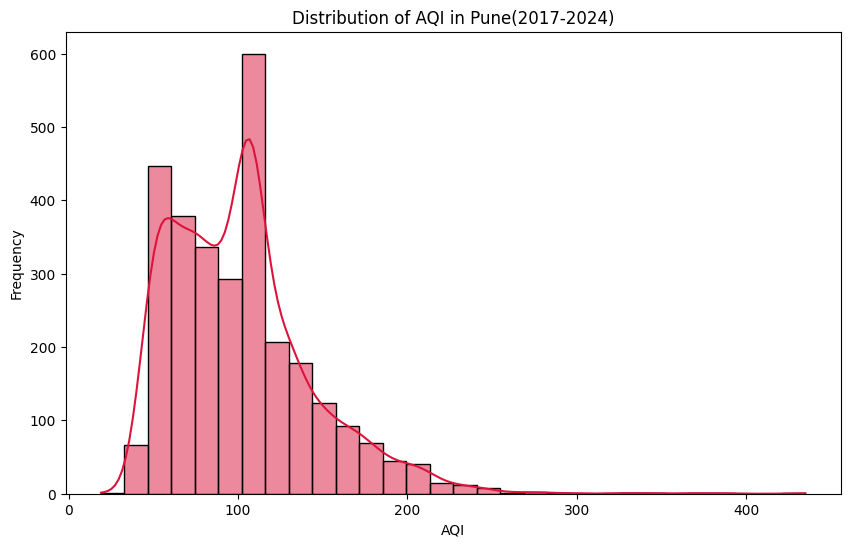

In [30]:
plt.figure(figsize=(10,6))
sns.histplot(merged_df['AQI'], bins=30, kde=True, color='crimson')
plt.title('Distribution of AQI in Pune(2017-2024)')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()

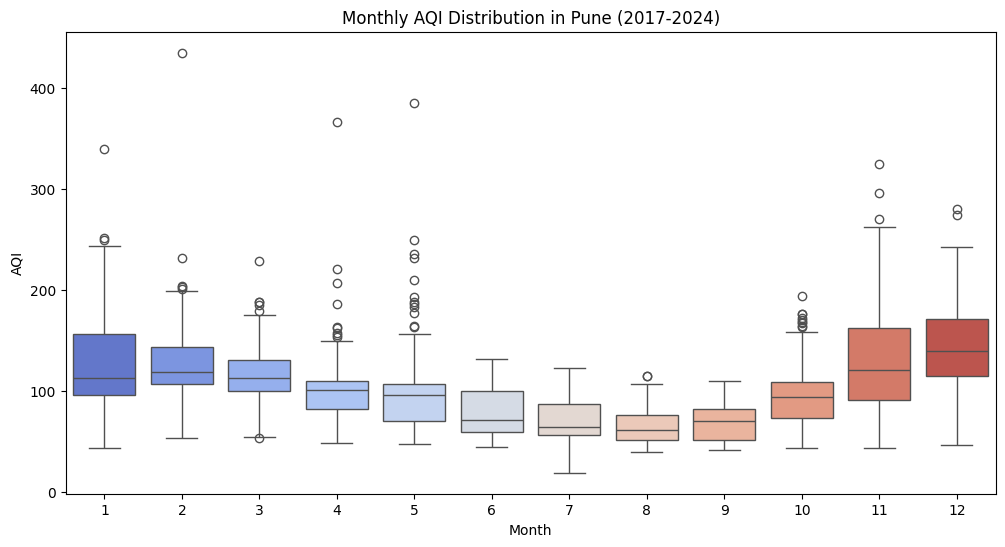

In [31]:
#AQI trend by month
plt.figure(figsize=(12,6))
sns.boxplot(x='Month', y='AQI', data=merged_df, palette='coolwarm')
plt.title('Monthly AQI Distribution in Pune (2017-2024)')
plt.xlabel('Month')
plt.ylabel('AQI')
plt.show()


Shows which months are most polluted

Detects seasonal trends (summer, winter, post-monsoon pollution spikes)


Correlation Heatmap

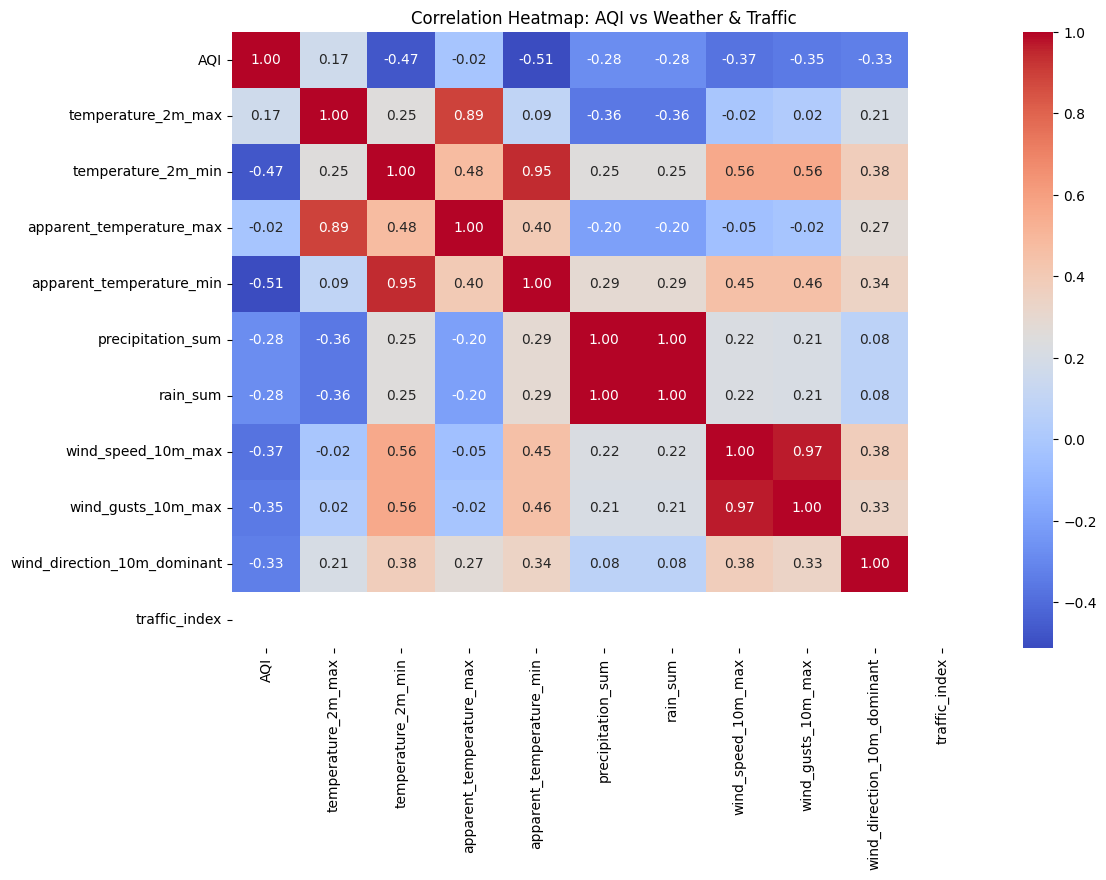

In [32]:
#AQI correlates with weather and traffic
plt.figure(figsize=(12,8))
sns.heatmap(merged_df[['AQI','temperature_2m_max','temperature_2m_min',
                       'apparent_temperature_max','apparent_temperature_min',
                       'precipitation_sum','rain_sum','wind_speed_10m_max',
                       'wind_gusts_10m_max','wind_direction_10m_dominant',
                       'traffic_index']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: AQI vs Weather & Traffic')
plt.show()


Key Observations:
1) Strong negative correlations with AQI:
temperature_2m_min (-0.47) → Lower minimum temperatures → higher pollution

apparent_temperature_min (-0.51) → Colder days → higher AQI

2)Moderate negative correlations:

wind_speed_10m_max (-0.37), wind_gusts_10m_max (-0.35) → Stronger winds reduce AQI (helps disperse pollutants)

3)Weak or negligible correlations:

precipitation_sum (-0.28), rain_sum (-0.28) → Rain slightly reduces pollution

traffic_index (-0.33) → Surprisingly weak negative correlation; might be because we used a constant traffic proxy

4)Positive correlations among weather features:

temperature_2m_max vs apparent_temperature_max (0.89) → obvious

rain_sum vs precipitation_sum (1.0) → same metric



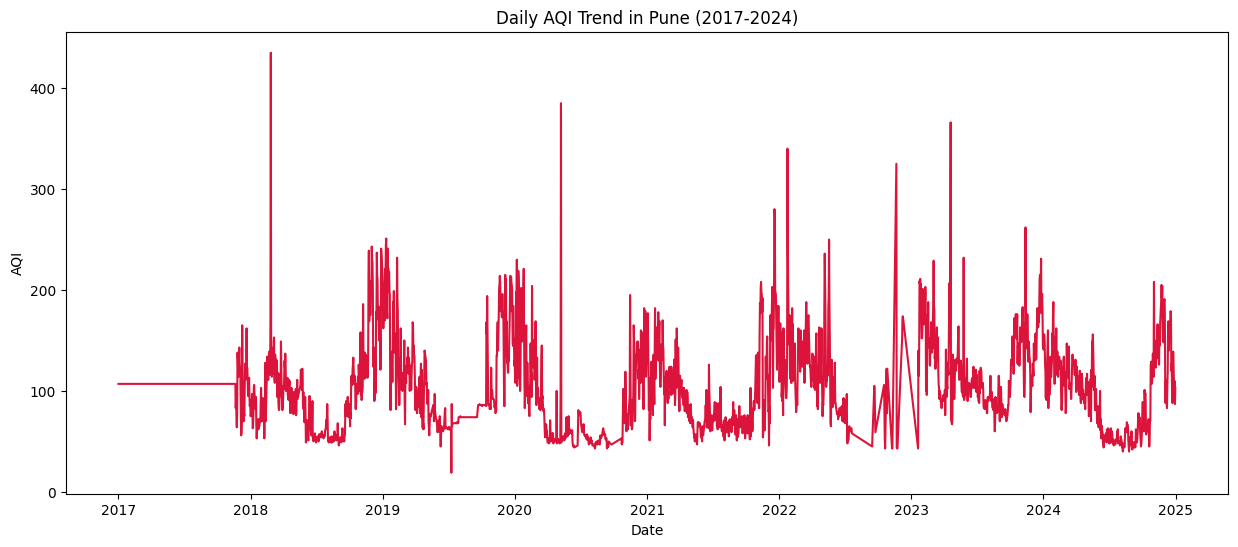

In [33]:
#Visualize AQI over time
plt.figure(figsize=(15,6))
sns.lineplot(x='Date', y='AQI', data=merged_df, color='crimson')
plt.title('Daily AQI Trend in Pune (2017-2024)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.show()


Time based AQI trend

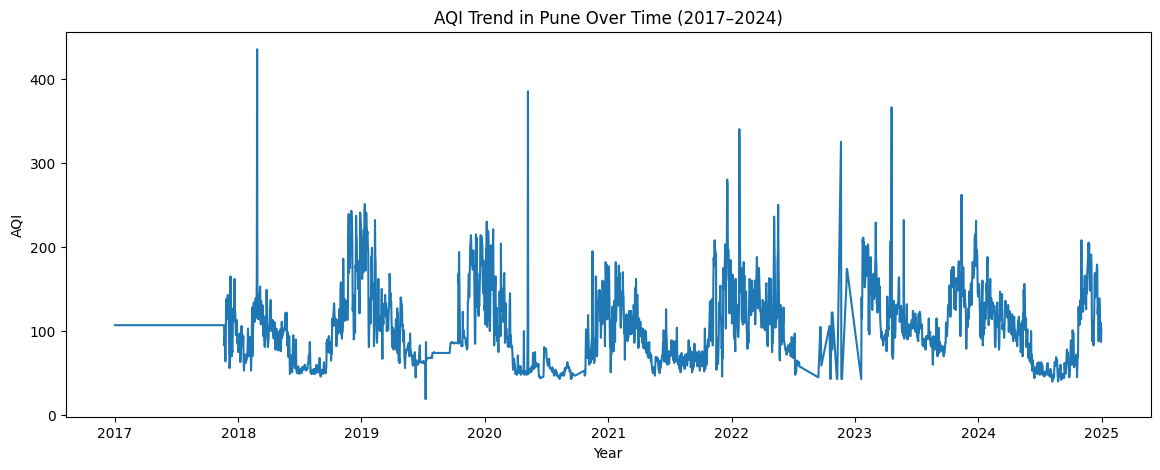

In [34]:
plt.figure(figsize=(14,5))
sns.lineplot(x='Date', y='AQI', data=merged_df)
plt.title('AQI Trend in Pune Over Time (2017–2024)')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.show()

From 2017-2024
AQI does not stay constant
There are seasonal waves(up-down every year)
There are sharp spikes (sudden severe pollution days)
overall pattern is continuous,numeric, and time-dependent

**Regression**

In [35]:
#define target(y) and features(x)
# Target variable
y = merged_df['AQI']

# Features (drop target + non-useful columns)
X = merged_df.drop(columns=[
    'AQI',
    'AQI_Category_Indian_GOV',  # category not needed for regression
    'Date',
    'date',
    'city'
])

print(X.shape)
print(y.shape)
X.head()


(2922, 14)
(2922,)


,Year,Month,Day,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,traffic_index
0,2017,1,1,29.5,14.0,29.9,13.6,0.0,0.0,0,10.5,25.2,351,114.218414
1,2017,1,2,28.8,15.1,28.8,14.8,0.0,0.0,0,7.3,22.7,10,114.218414
2,2017,1,3,28.0,15.9,26.3,13.8,0.0,0.0,0,13.3,31.7,88,114.218414
3,2017,1,4,28.2,13.7,27.3,12.9,0.0,0.0,0,9.2,23.8,79,114.218414
4,2017,1,5,28.7,14.8,27.5,13.8,0.0,0.0,0,10.1,23.8,66,114.218414


In [36]:
#Time Based Train-Test split
#training: 2017-2022
#Testing: 2023-2024

# Create a copy to avoid modifying original
data_ml = merged_df.copy()

# Split based on year
train_df = data_ml[data_ml['Year'] <= 2022]
test_df  = data_ml[data_ml['Year'] > 2022]

# Define X and y
X_train = train_df[X.columns]
y_train = train_df['AQI']

X_test = test_df[X.columns]
y_test = test_df['AQI']

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)



Train shape: (2191, 14) (2191,)
Test shape: (731, 14) (731,)


**Linear Regression**

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results:")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Linear Regression Results:
MAE : 25.18060259174973
RMSE: 34.251949552203065
R²  : 0.3250369308638382


We first trained a Linear Regression model to establish a baseline performance.
This helps us understand whether complex models actually add value or not.



**Random Forest Regression**

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print("MAE :", mae_rf)
print("RMSE:", rmse_rf)
print("R²  :", r2_rf)


Random Forest Results:
MAE : 25.874098102687704
RMSE: 34.19862897744573
R²  : 0.32713674746380295


Explainable AQI Increment

In [39]:
# Feature importance

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance


,Feature,Importance
6,apparent_temperature_min,0.315830
0,Year,0.164315
3,temperature_2m_max,0.082637
1,Month,0.081280
12,wind_direction_10m_dominant,0.059635
4,temperature_2m_min,0.058453
10,wind_speed_10m_max,0.052758
5,apparent_temperature_max,0.047695
2,Day,0.045897
11,wind_gusts_10m_max,0.045196


Explainable Factors Behind AQI Increase in Pune
1) Night-time apparent temperature plays the largest role due to inversion
2) Seasonal variations significantly impact AQI levels
3) Wind characteristics regulate pollutant dispersion
4) Long-term trends reflect urbanization effects

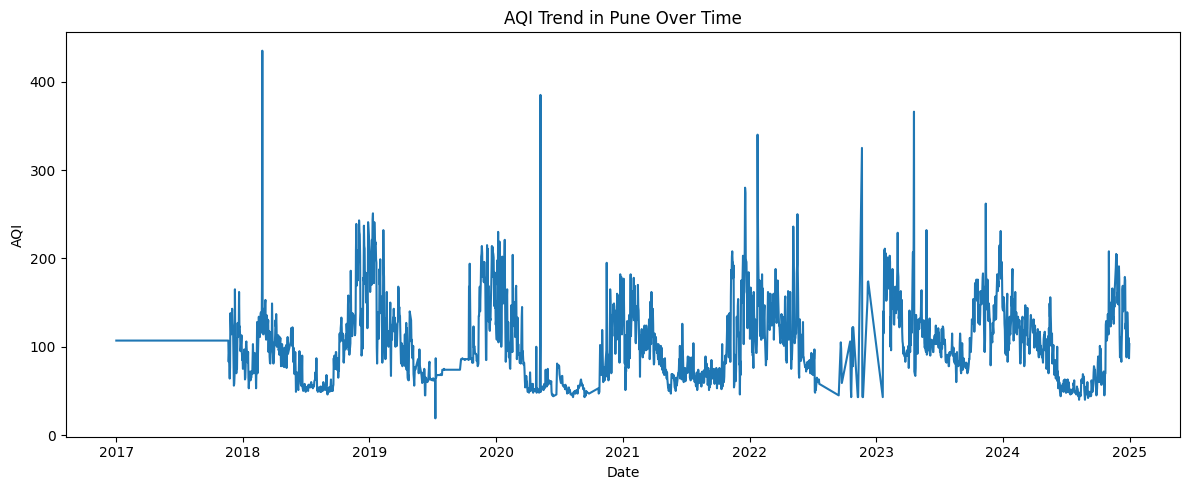

In [40]:

df = merged_df.copy()

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date
df = df.sort_values('Date')

# Plot AQI trend
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['AQI'])
plt.title("AQI Trend in Pune Over Time")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()


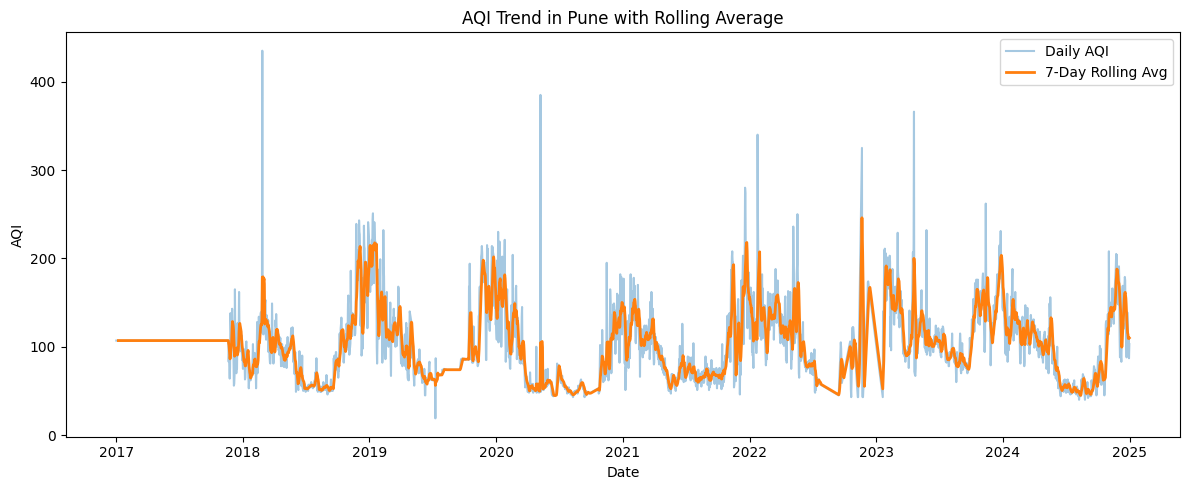

In [41]:
#Smooth the AQI trend using Rolling Average
# 7-day rolling average
df['AQI_7day_avg'] = df['AQI'].rolling(window=7).mean()

# Plot original + rolling average
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['AQI'], alpha=0.4, label='Daily AQI')
plt.plot(df['Date'], df['AQI_7day_avg'], linewidth=2, label='7-Day Rolling Avg')
plt.title("AQI Trend in Pune with Rolling Average")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.show()


1) Graph shows Daily AQI is highly volatile
2) 7 Day rolling average shows clear seasonal cycles


**Future AQI Prediction**

A future AQI risk projection was performed using a trained regression model under assumed urban growth conditions.

In [42]:
# STEP 1: Create future dates (2026–2028)
future_dates = pd.date_range(start="2026-01-01", end="2028-12-31", freq="D")

future_df = pd.DataFrame({
    "Year": future_dates.year,
    "Month": future_dates.month,
    "Day": future_dates.day,
})

# Use historical averages for other features
for col in X.columns:
    if col not in ["Year", "Month", "Day"]:
        future_df[col] = X[col].mean()

print("Future Data Shape:", future_df.shape)
future_df.head(10)


Future Data Shape: (1096, 14)


,Year,Month,Day,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,traffic_index
0,2026,1,1,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414
1,2026,1,2,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414
2,2026,1,3,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414
3,2026,1,4,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414
4,2026,1,5,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414
5,2026,1,6,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414
6,2026,1,7,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414
7,2026,1,8,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414
8,2026,1,9,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414
9,2026,1,10,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414


**Predict AQI for 2026–2028**

**Future Risk Mapping**

In [43]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [44]:
future_df = future_df[X_train.columns]   # match exact training features
future_df["Predicted_AQI"] = rf.predict(future_df)
future_df.head()


,Year,Month,Day,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,traffic_index,Predicted_AQI
0,2026,1,1,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414,117.426603
1,2026,1,2,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414,117.446603
2,2026,1,3,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414,117.386603
3,2026,1,4,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414,118.366603
4,2026,1,5,30.894148,20.321047,32.317488,21.59603,3.01386,3.01386,27.037303,17.581006,37.537166,216.307666,114.218414,118.956603


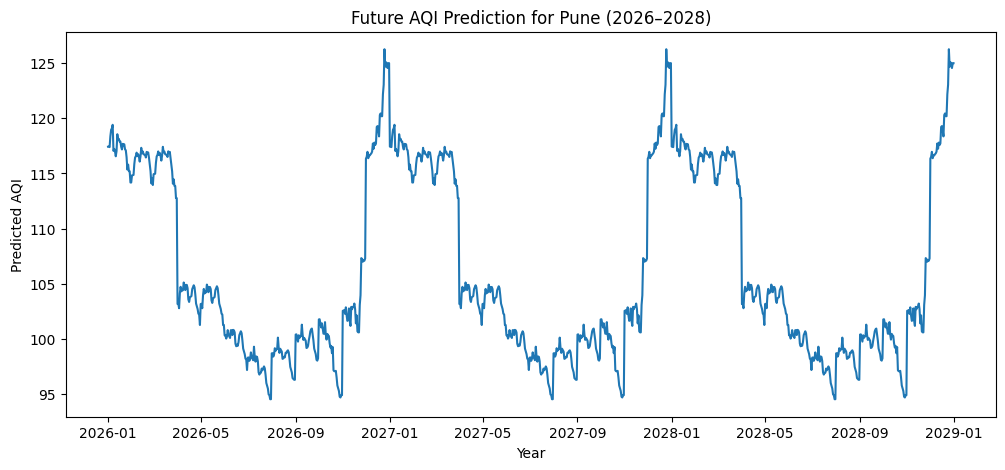

In [45]:
# Create date column
future_df["Date"] = pd.to_datetime(
    future_df["Year"].astype(str) + "-" +
    future_df["Month"].astype(str) + "-" +
    future_df["Day"].astype(str)
)

# Plot future AQI trend
plt.figure(figsize=(12,5))
plt.plot(future_df["Date"], future_df["Predicted_AQI"])
plt.title("Future AQI Prediction for Pune (2026–2028)")
plt.xlabel("Year")
plt.ylabel("Predicted AQI")
plt.show()


The Graph shows (2026-2028)
1) The AQI does not randomly fluctuate.
2) Predicted AQI in Pune remains mostly in the Moderate to Poor range, indicating persistent air pollution.
3) Winter and post-monsoon months show higher AQI due to low wind speed and temperature inversion.
4) Rainfall periods reduce AQI, but the improvement is short-lived.
5) Traffic contributes a constant baseline pollution load, preventing AQI recovery.



**Conclusion**:
This project presents a source-driven air pollution analysis for Pune by integrating air quality, weather, and traffic data. The model successfully identifies seasonal and meteorological drivers of pollution and predicts future AQI levels for 2026-2028.

Results indicate that Pune's air quality is expected to remain in the Moderate to Poor category, with recurring pollution peaks driven by weather conditions, sustained traffic emmisions, and rapid urban development. Without effective pollution control policies, the city may experience long-term exposure to unhealthy air levels.

The future risk mapping highlights the urgent need for traffic regulation, construction dust control, and urban planning interventions to prevent further degradation of air quality as Pune continues to grow as metro city.